In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

from sim_handling2 import Simulation,loadSim
from diffusionstuff8 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

In [21]:
%matplotlib widget

In [39]:
 #set up and run and plot a new simulation
test_2d_asym = Simulation(f2d, (200,250), method='RK45')

test_2d_asym.discretization_halt = False

#try a noisy simulation
test_2d_asym.noisy_init = False

test_2d_asym.float_params['DoverdeltaX2'] *= 2 # raised to lower parameter product value
test_2d_asym.layermax = 250
#test_2d_asym.sigmastepmax= -0.01 #ablation
test_2d_asym.sigmastepmax= 0.195 #growth - lowered to lower parameter product value
test_2d_asym.center_reduction = 0.025
test_2d_asym.center_reduction = 0.003 # lowered to lower parameter product value
#test_2d_asym.deltaT *= 10 #increase time step to decrease number of steps saved

#_plot = test_2d_asym.plot(tot=True,completion=1)
#anim = test_2d_asym.animate(ice=True,surface=True, ret=True, focus_on_growth=True)

breaking because reached max number of layers grown


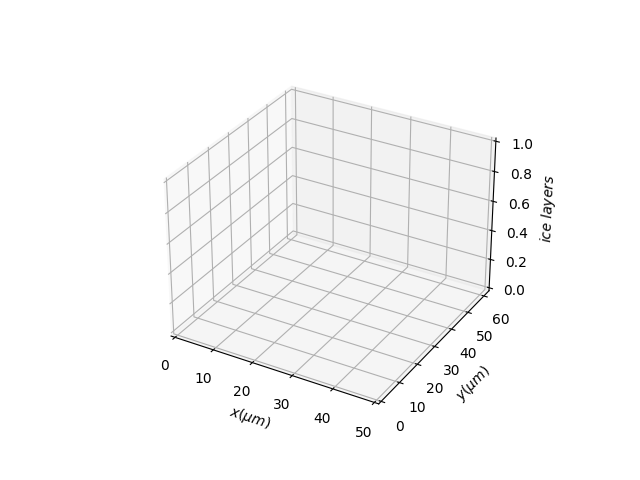

In [41]:
#animate the simulation (runs if needed)
#test_2d_asym.run(halve_time_res=True) #only saves half the time steps since it is a huge simulation

anim = test_2d_asym.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

In [40]:
#calculating Nss vs parameter thingy

# N_ss = # number of steps to steady state 

Lx,Ly = test_2d_asym.shape
sigma = test_2d_asym.sigmastepmax
beta = 0.65
nu_kin =test_2d_asym._extra_vars.get('nu_kin')
D = test_2d_asym._extra_vars.get('D')

c_r = test_2d_asym.center_reduction /100

x = nu_kin*Lx*Ly*sigma*(c_r)**beta / (D*1000)
print(x)

#trying other parameters to see if it can even be ballpark in a steady state forming regime
Lx = Ly = 25

x = nu_kin*Lx*Ly*sigma*(c_r)**beta / (D*1000)
print(x)

D = test_2d_asym.float_params['DoverdeltaX2']

x = nu_kin*Lx*Ly*sigma*(c_r)**beta / (D*1000)
print(x)

2743.4655787319007
34.29331973414876
1.0824638182794863


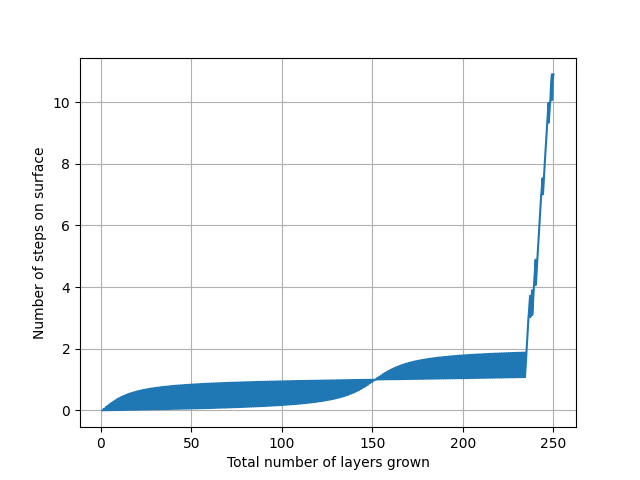

In [42]:
#graph number of steps over time
Ntot = test_2d_asym.getNtot()
#Ntot = cycle_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if test_2d_asym.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0,0]+test_2d_asym.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0,0],maxes-mins)

plt.grid()

In [29]:
#continuation of previous simulation
#start a second simulation starting with the ending surface of the first 
# as the initial surface

#create 1d sim and graph number of steps over time
cycle_sim =  Simulation(f2d, (test_2d_asym.shape[0],test_2d_asym.shape[1]), method=test_2d_asym.method, rtol=test_2d_asym.rtol)

#keep general params same
cycle_sim.layermax = 1000 #st_2d_asym.layermax * 1.5 #make sure it reaches steady state
cycle_sim.float_params['DoverdeltaX2'] = test_2d_asym.float_params['DoverdeltaX2'] 
cycle_sim.sigma0 = test_2d_asym.sigma0
cycle_sim.center_reduction = test_2d_asym.center_reduction
cycle_sim.deltaT = test_2d_asym.deltaT #increase time step to decrease number of steps saved?
cycle_sim.noisy_init = test_2d_asym.noisy_init

#set up initial surface
cycle_sim.nonstd_init = True
ntots = test_2d_asym.getNtot()
cycle_sim.startingNtot = ntots[len(ntots)//2] #start with the middle of the last simulation, before discretzation error

#set to ablation run
cycle_sim.sigmastepmax = 0.20 


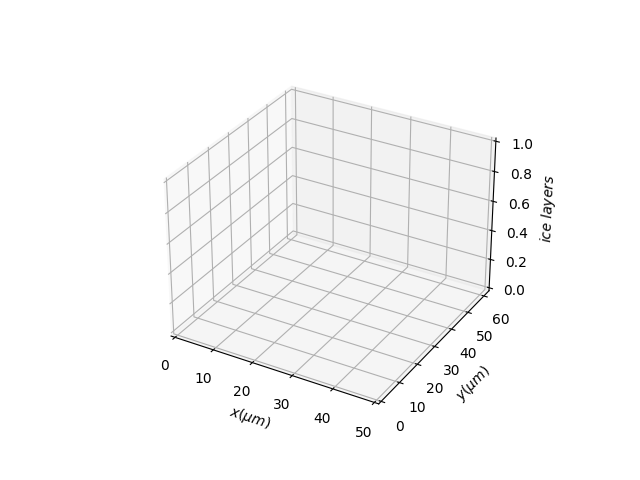

In [30]:
#animate ablation of growth ending surface
anim = cycle_sim.animate(ret=True, focus_on_growth=True, proportionalSpeed=False)

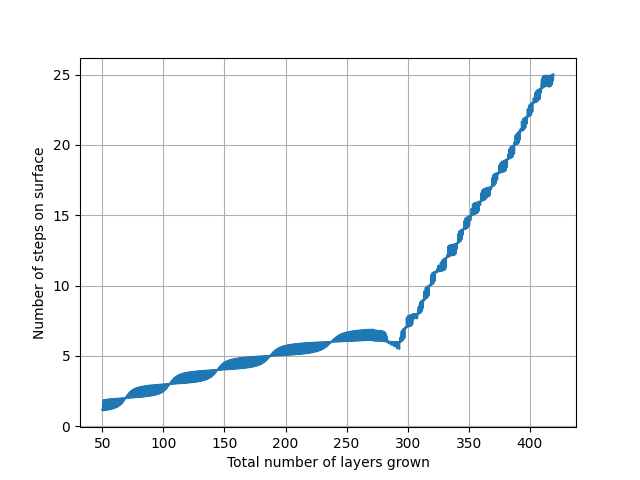

In [31]:
#graph number of steps over time for second simulation
Ntot = cycle_sim.getNtot()
#Ntot = cycle_sim.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])

#print(maxes,mins)
plt.figure()
ax = plt.subplot(111)

ax.set_ylabel('Number of steps on surface')

if cycle_sim.sigmastepmax < 0: #ablation case
    ax.set_xlabel('Total number of layers ablated')
    ax.plot( Ntot[::-1,0,0]+cycle_sim.layermax,maxes-mins) #flipping to show ablation progress from left to right, adding layermax to show # layers ablated instead of negative # layers grown
else: #growth case   
    ax.set_xlabel('Total number of layers grown')
    ax.plot( Ntot[:,0,0],maxes-mins)

plt.grid()